<a href="https://colab.research.google.com/github/mayapatward/-k-anonymized-ratings/blob/main/collaborativefiltering_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
%%capture
!pip install pyspark
!pip install -U -q PyDrive
!apt-get update
# Download Java JDK Version 8
!apt install openjdk-8-jdk-headless -qq
!pip install scikit-surprise

In [123]:
%%capture
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import Reader, Dataset, NMF, SVD, SVDpp
from surprise.model_selection import cross_validate
from ast import literal_eval
from sklearn.model_selection import train_test_split


In [124]:
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [125]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

ValueError: ignored

In [127]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [126]:
##Collect data
READ_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/ratings_split/iter_1_fix/'

training_raw = spark.read.text(READ_PATH + "ratings_train.csv").rdd
validation_raw = spark.read.text(READ_PATH + "ratings_validation.csv").rdd
test_raw = spark.read.text(READ_PATH + "ratings_test.csv").rdd

In [129]:
def process(raw_data):
  parts = raw_data.map(lambda row: row.value.split(","))
  ratings_RDD_remove = parts.take(1)[0]
  parts = parts.filter(lambda p: p !=ratings_RDD_remove)
  ratingsRDD = parts.map(lambda p: Row(userId = int(p[0]), movieId = int(p[1]), rating = float(p[2])))
  df = spark.createDataFrame(ratingsRDD)
  return df

In [130]:
training_df = process(training_raw)
validation_df = process(validation_raw)
test_df = process(test_raw)

In [131]:
from operator import add

RANK_ = 10
REG_PARAM_ = 0.15
NONNEG_ = True
READ_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/ratings_split/iter_1_fix/'
klist = [5, 8, 12, 15, 20, 25]

In [134]:
model = ALS.train(training_df.rdd, rank = RANK_, nonnegative=True)

In [214]:
def predict(model, test_df):
  testdata = test_df.rdd.map(lambda p: (p[0], p[1]))
  predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
  ratesAndPreds = test_df.rdd.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
  MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()

  metrics = RegressionMetrics(ratesAndPreds.map(lambda x: x[1]))
  rmse = metrics.rootMeanSquaredError
  print("Mean Absolute Error = " + str(metrics.meanAbsoluteError))
  print("Root Mean Squared Error = " + str(metrics.rootMeanSquaredError))

  binaryRankings = test_df.rdd.map(lambda p: (p[0], p[1], 1) if p[2] > 3 else (p[0], p[1], 0))
  userRankings = binaryRankings.filter(lambda x: x[2]==1).map(lambda x: (x[0], x[1]))
  userRankings = userRankings.groupByKey().mapValues(list)


  recommendedRankings = model.recommendProductsForUsers(50)
  recommendedRankings = recommendedRankings.mapValues(lambda x: [r[1] for r in x])
  predictionAndLabels = userRankings.join(recommendedRankings).map(lambda x: x[1])
  metrics = RankingMetrics(predictionAndLabels)
  
  map = metrics.meanAveragePrecision
  precision = metrics.precisionAt(5)
  print("Mean Average Precision = " + str(metrics.meanAveragePrecision))
  print("Truncated Precision = "+ str(metrics.precisionAt(5)))


  print("Size of N: "+str(ratesAndPreds.count()))
  print("")
  return rmse, map, precision


In [211]:
predict(model, training_df)

Mean Absolute Error = 0.40360716979758754
Root Mean Squared Error = 0.561948415000344
Mean Average Precision = 0.002187892428103201
Truncated Precision = 0.006578947368421052
Size of N: 80769



In [212]:
predict(model, test_df)


Mean Absolute Error = 0.7472197952865403
Root Mean Squared Error = 0.9911376678010508
Mean Average Precision = 0.0002583460914914012
Truncated Precision = 0.004569420035149383
Size of N: 9697



In [111]:
def map_k(id_to_idx, idx_to_kanon,user_to_cluster, x):
  idx = id_to_idx[x[0]]
  if idx in idx_to_kanon.keys():
    return (idx_to_kanon[idx], x[1], x[2], 0)
  else:
    try:
      return (user_to_cluster[x[0]], x[1], x[2], 0)
    except:
      return (x[0], x[1], x[2], 1)

In [216]:
import operator
rmselist = []
maplist = []
precisionlist = []
for k in klist:
  print("Running k =", k)
  mappingpath_idtoidx = READ_PATH+"user_to_idx.json"
  mappingpath_idxtokanon = READ_PATH+ str(k)+"_anonymized_idx_to_kanon_idx.json"
  trainpath = READ_PATH+"postprocessed_anonymized/"+ str(k)+"_anonymized_processed.csv"

  user_to_cluster = Utility().get_closest_k_cluster_to_user_id(k)
  
  with open(mappingpath_idxtokanon, 'r') as f:
      idx_to_kanon = literal_eval(f.read())
  idx_to_kanon = {int(i): int(j) for i, j in idx_to_kanon.items()}

  with open(mappingpath_idtoidx, 'r') as f:
      id_to_idx = literal_eval(f.read())
  id_to_idx = {int(i): int(j) for i, j in id_to_idx.items()}

  ktrain_rdd = spark.read.text(trainpath).rdd
  ktrain_df = process(ktrain_rdd)
  ktrain_model = ALS.train(ktrain_df, rank = RANK_, nonnegative = True)

  mapped = test_df.rdd.map(lambda x: map_k(id_to_idx, idx_to_kanon,user_to_cluster, x))
  
  mapped_row = mapped.map(lambda x: Row(userId = int(x[0]), movieId = int(x[1]), rating = float(x[2])))
  thrownout = mapped.map(lambda x: x[3]).reduce(add)
  actual = spark.createDataFrame(mapped_row)  
  print("Number points not mapped to cluster: "+str(thrownout))
  rmse, map, precision = predict(ktrain_model, actual)
  rmselist += [rmse]
  maplist += [map]
  precisionlist += [precision]



Running k = 5
Number points not mapped to cluster: 0
Mean Absolute Error = 2.156990937233237
Root Mean Squared Error = 2.4791796110835973
Mean Average Precision = 0.03251933456798628
Truncated Precision = 0.12459016393442623
Size of N: 10417

Running k = 8
Number points not mapped to cluster: 0
Mean Absolute Error = 1.9001664010893722
Root Mean Squared Error = 2.253335184934015
Mean Average Precision = 0.03733829378960246
Truncated Precision = 0.12105263157894738
Size of N: 10835

Running k = 12
Number points not mapped to cluster: 31
Mean Absolute Error = 1.7230258279512545
Root Mean Squared Error = 2.0962033694568563
Mean Average Precision = 0.0435834448086305
Truncated Precision = 0.11600000000000002
Size of N: 11618

Running k = 15
Number points not mapped to cluster: 41
Mean Absolute Error = 1.5810792381945362
Root Mean Squared Error = 1.9670027496358822
Mean Average Precision = 0.04867712952070603
Truncated Precision = 0.10500000000000001
Size of N: 12024

Running k = 20
Number p

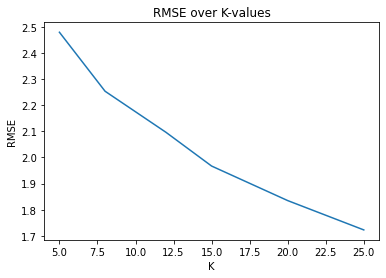

In [218]:
plt.plot(klist, rmselist)
plt.title("RMSE over K-values")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.show()

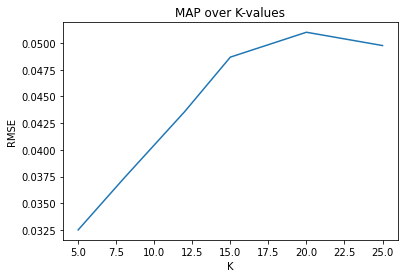

In [219]:
plt.plot(klist, maplist)
plt.title("MAP over K-values")
plt.xlabel("K")
plt.ylabel("RMSE")
plt.show()

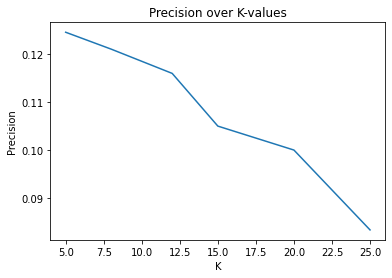

In [221]:
plt.plot(klist, precisionlist)
plt.title("Precision over K-values")
plt.xlabel("K")
plt.ylabel("Precision")
plt.show()

In [85]:
import os
import json
import numpy as np
import pandas as pd
COL_NAME_USER_ID = "userId"
COL_NAME_MOVIE_ID = "movieId"
COL_NAME_ITEM_ID = COL_NAME_MOVIE_ID
COL_NAME_RATING = "rating"
COL_NAME_MOVIE_RATINGS = "movies_and_ratings"


BASE_PATH = '/content/drive/MyDrive/CSE547_Final_Project/ml-100k/train_test_v2/rawdata_split/iter_1/'
class Utility:

    def __init__(self, _base_path:str=BASE_PATH, _user_id_col="userId", _movie_id_col="movieId", _rating_col="rating"):
        """Init the utility class

        Keyword arguments
        base_path -- The directory where files are located. 
        """

        if not os.path.isdir(_base_path):
            raise OSError(f'{_base_path} is not a directory')
        
        self.base_path = _base_path

        self.training_file = 'ratings_train.csv'
        self.test_file = 'ratings_test.csv'
        self.validation_file = 'ratings_validation.csv'

        self.user_to_idx_file = "user_to_idx.json"
        self.movie_to_idx_file = "movie_to_idx.json"

        self.k_anonymized_postfix = '_anonymized.csv'
        self.k_anonymized_map_postfix = '_anonymized_idx_to_kanon_idx.json'

        self.user_id_col=_user_id_col
        self.movie_id_col=_movie_id_col
        self.rating_col=_rating_col
    
    def euclidean_distance(self, point1, point2):
        return np.linalg.norm(point1 - point2) ** 2
    
    def manhattan_distance(self, point1, point2):
        return abs(point1 - point2).sum()
    
    def find_closest_point(self, points_list, point, metric='euclidean'):

        min_distance = float('inf')
        min_distance_idx = -1
        i = 0
        for p in points_list:
            if metric == 'euclidean':
                distance = self.euclidean_distance(p, point)
            elif metric == 'manhattan':
                self.manhattan_distance(p, point)
            else:
                print('Function not implemented!')

            if distance < min_distance:
                min_distance = distance
                min_distance_idx = i
            
            i += 1
        
        return min_distance_idx
    
    def flatten_matrix_into_dataframe(self, matrix):
      value_vars = [v for v in matrix.columns.values if v != COL_NAME_USER_ID]
      DEFAULT_VARIABLE_NAME_IN_MELT="variable"
      DEFAULT_VALUE_NAME_IN_MELT="value"
      movies_dict = self.get_movie_index()
      matrix = matrix \
        .melt(id_vars=[COL_NAME_USER_ID], value_vars=value_vars) \
        .rename(columns={DEFAULT_VARIABLE_NAME_IN_MELT: COL_NAME_MOVIE_ID, DEFAULT_VALUE_NAME_IN_MELT: COL_NAME_RATING}) \
        .apply(lambda x : pd.to_numeric(x, downcast='integer'))
      matrix[COL_NAME_MOVIE_ID] = matrix[COL_NAME_MOVIE_ID].apply(lambda x: movies_dict[x])
      matrix[COL_NAME_USER_ID] = matrix[COL_NAME_USER_ID] + 1
      matrix = matrix[matrix[COL_NAME_RATING] > 0]
      return matrix

    def get_training_data_file_path(self, k:int):
      return os.path.join(self.base_path, f"{k}{self.k_anonymized_postfix}")

    def get_test_data_file_path(self):
      return os.path.join(self.base_path, self.test_file)

    def get_training_data(self, k:int):
      mldf = pd.read_csv(self.get_training_data_file_path(k), header=None).reset_index().rename(columns={'index': COL_NAME_USER_ID})
      mldf= self.flatten_matrix_into_dataframe(mldf)
      return mldf, len(mldf[COL_NAME_USER_ID].unique()), len(mldf[COL_NAME_MOVIE_ID].unique())

    def get_training_data_for_evaluation(self):
      mldf = pd.read_csv(self.get_training_data_path())
      return self._group_and_get_sets_for_evaluation(mldf)

    def get_test_data(self):
      return pd.read_csv(self.get_test_data_file_path()).apply(lambda x : pd.to_numeric(x, downcast='integer'))

    def _group_and_get_sets_for_evaluation(self, df):
      testdf=df.sort_values(by=COL_NAME_RATING, ascending=False)
      grouped=testdf.groupby(COL_NAME_USER_ID).agg({COL_NAME_MOVIE_ID:lambda x: list(x), COL_NAME_RATING:lambda x: list(x)})
      grouped[COL_NAME_MOVIE_RATINGS] = grouped.apply(lambda x: list(zip(x[COL_NAME_MOVIE_ID], x[COL_NAME_RATING])), axis=1)
      grouped=grouped.drop(columns=[COL_NAME_RATING])
      return grouped

    def get_unanonymized_training_data(self):
      df = pd.read_csv(self.get_training_data_path())
      return df.apply(pd.to_numeric), len(df[COL_NAME_USER_ID].unique()), len(df[COL_NAME_MOVIE_ID].unique())

    def get_test_data_for_evaluation(self):
      testdf=Utility().get_test_data()
      return self._group_and_get_sets_for_evaluation(testdf)
  
    def get_training_data_path(self, base_path=""):
        """Get path to training file

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.training_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')
        
        return file_path

    def get_test_data_path(self, base_path=""):
        """Get path to test file

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.test_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def get_validation_data_path(self, base_path=""):
        """Get path to validation file

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.validation_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def get_train_data_user_map_path(self, base_path=""):
        """Get path to user id to train index file map

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.user_to_idx_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def get_train_data_movie_map_path(self, base_path=""):
        """Get path to movie id to train index file map

        Keyword arguments
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        file_path = os.path.join(base_path, self.movie_to_idx_file)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path

    def get_k_anonymized_data_path(self, k, base_path=""):
        """Get path to k-anonymzied file

        Keyword arguments
        k -- 
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        k_file_name = str(k) + self.k_anonymized_postfix

        file_path = os.path.join(base_path, k_file_name)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def _coalesce_path(self,path1, path2):
      return path1 if path1 != "" else path2

    def get_utility_matrix_from_train(self, base_path=""):
        base_path = self._coalesce_path(base_path, self.base_path)
        complete_file_path = os.path.join(base_path, self.training_file)
        if not os.path.exists(complete_file_path):
            raise OSError(f'{complete_file_path} is not a file')
        
        df = pd.read_csv(complete_file_path)
        
        movie_to_idx_path = self.get_train_data_movie_map_path(base_path)
        with open(movie_to_idx_path) as json_file:
            movie_id_to_idx_dict = json.load(json_file)

        users = df.userId.unique()
        test_user_dict = {users[i]: i for i in range(len(users))}

        num_users = len(df.userId.unique())
        num_movies = len(movie_id_to_idx_dict) + 1
        utility_matrix = np.zeros((num_users, num_movies))

        for index, row in df.iterrows():
            movie_id, rating = str(int(row[self.movie_id_col])), float(row[self.rating_col])
            utility_matrix[test_user_dict[row[self.user_id_col]]][0] = int(row[self.user_id_col])
            
            if movie_id in movie_id_to_idx_dict.keys():
                utility_matrix[test_user_dict[row[self.user_id_col]]][movie_id_to_idx_dict[movie_id]] = rating
            else:
                print(f'Movie ID {movie_id} not found!')
        
        return utility_matrix
    
    def get_k_anonymized_map_path(self, k, base_path=""):
        """Get path to k-anonymzied map. 
        {k}_anonymized_idx_to_kanon_idx.json --> the mapping from user index 
        (row in the ratings_train.csv) to the row index in the 
        corresponding {k}_anonymized.csv file

        Keyword arguments
        k -- 
        base_path -- The directory where files are located. 
        """
        if not base_path:
            base_path = self.base_path
        
        if not os.path.isdir(base_path):
            raise OSError(f'{base_path} is not a directory')
        
        k_file_name = str(k) + self.k_anonymized_map_postfix
        
        file_path = os.path.join(base_path, k_file_name)
        if not os.path.exists(file_path):
            raise OSError(f'{file_path} is not a directory')

        return file_path
    
    def get_movie_index(self):
      movie_to_idx_path = self.get_train_data_movie_map_path(self.base_path)
      with open(movie_to_idx_path) as json_file:
          movie_id_to_idx_dict = json.load(json_file)
      return {v:int(k) for k,v in movie_id_to_idx_dict.items()}

    def get_movie_to_col_index(self):
      movie_to_idx_path = self.get_train_data_movie_map_path(self.base_path)
      with open(movie_to_idx_path) as json_file:
          movie_id_to_idx_dict = json.load(json_file)
      return {int(k):v for k,v in movie_id_to_idx_dict.items()}

    def get_feature_vector_for_user(self, movie_ratings:list, base_path=""):
        """Returns a vector, with the same dimentions as the 
        training dataset. 

        Keyword arguments
        movie_ratings -- A list of tuples. Each tuple should be
        as follows: (movie_id, rating)
        """
        movie_to_idx_path = self.get_train_data_movie_map_path(base_path)
        with open(movie_to_idx_path) as json_file:
            movie_id_to_idx_dict = json.load(json_file)
        
        feature_vec = [0 for _ in range(len(movie_id_to_idx_dict))]
        for movie_id, rating in movie_ratings:
            movie_id, rating = str(movie_id), int(rating)

            if movie_id in movie_id_to_idx_dict.keys():
                feature_vec[movie_id_to_idx_dict[movie_id]] = rating
            else:
                print(f'Movie ID {movie_id} not found!')
        
        return feature_vec
    
    def get_closest_k_cluster_to_user_id(self, k:int, metric="euclidean", base_path=""):
        id_to_idx_path = self.get_train_data_user_map_path(base_path)
        idx_to_kidx_path = self.get_k_anonymized_map_path(k, base_path)
        k_anon_data_path = self.get_k_anonymized_data_path(k, base_path)

        with open(id_to_idx_path) as json_file:
            id_to_idx_dict = json.load(json_file)
        
        with open(idx_to_kidx_path) as json_file:
            idx_to_kidx_path_dict = json.load(json_file)

        k_anaon_data = pd.read_csv(k_anon_data_path, sep=',', header=None).values
        
        u_matrix = self.get_utility_matrix_from_train(base_path)
        user_to_cluster_dict = {}
        for um in u_matrix:
            user_id = str(int(um[0]))
            row_vec = um[1:]
        
            # Easy case - We have trained on this user before
            # Just need to lookup, to see what cluster they belong to
            try:
              if user_id in id_to_idx_dict.keys() and\
              str(id_to_idx_dict[user_id]) in idx_to_kidx_path_dict.keys():            
                  user_to_cluster_dict[int(user_id)] = idx_to_kidx_path_dict[str(id_to_idx_dict[user_id])]
              else:
                  # print(f'{user_id} not found in training data!')
                  user_to_cluster_dict[int(user_id)] = self.find_closest_point(k_anaon_data, row_vec)
                 # print(f'{user_id} mapped to {user_to_cluster_dict[int(user_id)]}')
            except:
              print(type(k_anon_data), " ", type(row_vec))
              raise
        
        return user_to_cluster_dict